In [54]:
import urllib.request
import os

In [55]:
url = "https://hbiostat.org/data/repo/titanic3.xls"
filepath = "data/titanic3.xls"
if not os.path.isfile(filepath):
    result = urllib.request.urlretrieve(url, filepath)
    print("downloaded:", result)

In [56]:
import numpy as np
import pandas as pd

In [57]:
all_df = pd.read_excel(filepath)

In [58]:
all_df[:2]

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"


In [59]:
cols = ["survived", "name", "pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"]
all_df = all_df[cols]

删除name字段

In [60]:
df = all_df.drop(["name"], axis=1)

找出含有null值的字段

In [61]:
all_df.isnull().sum()

survived      0
name          0
pclass        0
sex           0
age         263
sibsp         0
parch         0
fare          1
embarked      2
dtype: int64

In [62]:
age_mean = df['age'].mean()
df['age'] = df['age'].fillna(age_mean)

In [63]:
fare_mean = df['fare'].mean()
df['fare'] = df['fare'].fillna(fare_mean)

In [64]:
df['sex'] = df['sex'].map({'female': 0, 'male': 1}).astype(int)

In [65]:
x_OneHot_df = pd.get_dummies(data=df, columns=["embarked"])

In [66]:
ndarray = x_OneHot_df.values

In [67]:
ndarray.shape

(1309, 10)

In [68]:
ndarray[:2]

array([[1, 1, 0, 29.0, 0, 0, 211.3375, False, False, True],
       [1, 1, 1, 0.9167, 1, 2, 151.55, False, False, True]], dtype=object)

In [69]:
Label = ndarray[:, 0]
Features = ndarray[:, 1:]

In [70]:
Label[:2]

array([1, 1], dtype=object)

In [71]:
Features[:2]

array([[1, 0, 29.0, 0, 0, 211.3375, False, False, True],
       [1, 1, 0.9167, 1, 2, 151.55, False, False, True]], dtype=object)

In [72]:
from sklearn import preprocessing

In [73]:
minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))

In [74]:
scaledFeatures = minmax_scale.fit_transform(Features)

In [75]:
scaledFeatures[:2]

array([[0.        , 0.        , 0.36116884, 0.        , 0.        ,
        0.41250333, 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.00939458, 0.125     , 0.22222222,
        0.2958059 , 0.        , 0.        , 1.        ]])

In [76]:
msk = np.random.rand(len(all_df)) < 0.8
train_df = all_df[msk]
test_df = all_df[~msk]

In [77]:
print("total:", len(all_df),
      "train:", len(train_df),
      "test:", len(test_df))

total: 1309 train: 1049 test: 260


In [102]:
def PreprocessData(raw_df):
    df = raw_df.drop(["name"], axis=1)
    age_mean = df["age"].mean()
    df["age"] = df["age"].fillna(age_mean)
    fare_mean = df["fare"].mean()
    df["fare"] = df["fare"].fillna(fare_mean)
    df["sex"] = df["sex"].map({"female": 0, "male": 1}).astype(int)
    x_OneHot_df = pd.get_dummies(data=df, columns=["embarked"])

    ndarray = x_OneHot_df.values
    Features = ndarray[:, 1:]
    Label = ndarray[:, 0]

    minmax_scale = preprocessing.MinMaxScaler(feature_range=(0, 1))
    scaledFeatures = minmax_scale.fit_transform(Features)

    return scaledFeatures.astype('float32'), Label.astype('float32')

In [103]:
train_Features, train_Label = PreprocessData(train_df)
test_Features, test_Label = PreprocessData(test_df)

In [104]:
train_Features[:2]

array([[0.        , 1.        , 0.00939458, 0.125     , 0.22222222,
        0.2958059 , 0.        , 0.        , 1.        ],
       [0.        , 0.        , 0.0229641 , 0.125     , 0.22222222,
        0.2958059 , 0.        , 0.        , 1.        ]], dtype=float32)

In [105]:
train_Label[:2]

array([1., 0.], dtype=float32)

## 建立模型

In [106]:
from keras.src.models import Sequential
from keras.src.layers import Dense, Dropout

In [107]:
model = Sequential()

In [108]:
model.add(Dense(units=40,
                input_dim=9,
                kernel_initializer="uniform",
                activation="relu"))

/Users/mikeshinoda/Library/Caches/pypoetry/virtualenvs/tensorflow-plus-keras-PjLLcQ39-py3.12/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [109]:
model.add(Dense(units=30,
                kernel_initializer="uniform",
                activation="relu"))

In [110]:
model.add(Dense(units=1,
                kernel_initializer="uniform",
                activation="sigmoid"))

## 开始训练

In [111]:
model.compile(loss="binary_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

In [112]:
train_history = model.fit(x=train_Features,
                          y=train_Label,
                          validation_split=0.1,
                          epochs=30,
                          batch_size=30,
                          verbose=2)

Epoch 1/30
32/32 - 1s - 21ms/step - accuracy: 0.5911 - loss: 0.6895 - val_accuracy: 0.7714 - val_loss: 0.6706
Epoch 2/30
32/32 - 0s - 943us/step - accuracy: 0.6314 - loss: 0.6601 - val_accuracy: 0.7714 - val_loss: 0.5783
Epoch 3/30
32/32 - 0s - 975us/step - accuracy: 0.6811 - loss: 0.5916 - val_accuracy: 0.8095 - val_loss: 0.4918
Epoch 4/30
32/32 - 0s - 879us/step - accuracy: 0.7648 - loss: 0.5238 - val_accuracy: 0.8095 - val_loss: 0.4641
Epoch 5/30
32/32 - 0s - 880us/step - accuracy: 0.7712 - loss: 0.4879 - val_accuracy: 0.8095 - val_loss: 0.4393
Epoch 6/30
32/32 - 0s - 932us/step - accuracy: 0.7744 - loss: 0.4757 - val_accuracy: 0.8095 - val_loss: 0.4307
Epoch 7/30
32/32 - 0s - 894us/step - accuracy: 0.7744 - loss: 0.4712 - val_accuracy: 0.8095 - val_loss: 0.4311
Epoch 8/30
32/32 - 0s - 931us/step - accuracy: 0.7712 - loss: 0.4659 - val_accuracy: 0.8095 - val_loss: 0.4245
Epoch 9/30
32/32 - 0s - 903us/step - accuracy: 0.7881 - loss: 0.4645 - val_accuracy: 0.8095 - val_loss: 0.4239
Ep

In [113]:
import matplotlib.pyplot as plt


def show_train_history(train_history, train, validation):
    plt.plot(train_history.history[train])
    plt.plot(train_history.history[validation])
    plt.title("Train History")
    plt.ylabel(train)
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

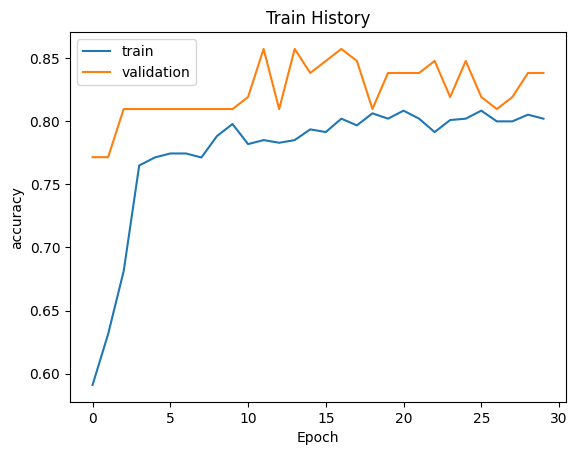

In [114]:
show_train_history(train_history, "accuracy", "val_accuracy")

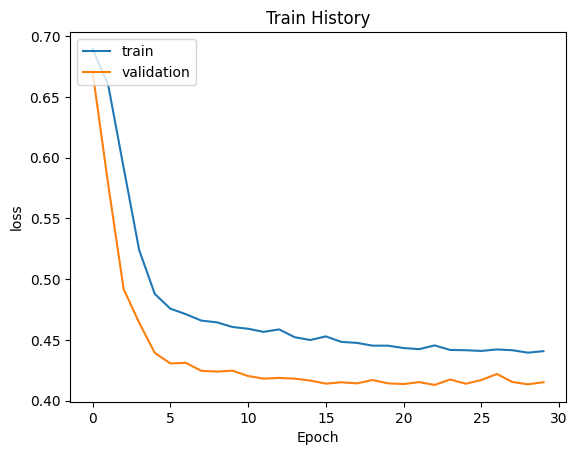

In [115]:
show_train_history(train_history, "loss", "val_loss")

In [116]:
scores = model.evaluate(x=test_Features,
                        y=test_Label)

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - accuracy: 0.8071 - loss: 0.4658


In [117]:
scores[1]

0.7846153974533081

## 加入Jack和Rose的数据

In [118]:
Jack = pd.Series([0, "Jack", 3, "male", 23, 1, 0, 5.0000, 'S'])
Rose = pd.Series([1, "Rose", 1, "female", 20, 1, 0, 100.0000, 'S'])

In [119]:
JR_df = pd.DataFrame([list(Jack), list(Rose)],
                     columns=["survived", "name", "pclass", "sex", "age", "sibsp", "parch", "fare", "embarked"])

In [120]:
all_df = pd.concat([all_df, JR_df])

In [121]:
all_df[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked
0,0,Jack,3,male,23.0,1,0,5.0,S
1,1,Rose,1,female,20.0,1,0,100.0,S


In [122]:
all_Features, Label = PreprocessData(all_df)

In [123]:
all_probability = model.predict(all_Features)

41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 587us/step


In [124]:
all_probability[:10]

array([[0.9737022 ],
       [0.5050906 ],
       [0.97008103],
       [0.31839016],
       [0.96813816],
       [0.24748176],
       [0.9465029 ],
       [0.28785327],
       [0.9517712 ],
       [0.257601  ]], dtype=float32)

In [125]:
pd = all_df
pd.insert(len(all_df.columns),
          "probability", all_probability)

In [126]:
pd[-2:]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,0,Jack,3,male,23.0,1,0,5.0,S,0.126697
1,1,Rose,1,female,20.0,1,0,100.0,S,0.971795


In [127]:
pd[(pd["survived"] == 0) & (pd["probability"] > 0.9)]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
2,0,"Allison, Miss. Helen Loraine",1,female,2.0,1,2,151.5500,S,0.970081
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0,1,2,151.5500,S,0.968138
105,0,"Evans, Miss. Edith Corse",1,female,36.0,0,0,31.6792,C,0.982675
169,0,"Isham, Miss. Ann Elizabeth",1,female,50.0,0,0,28.7125,C,0.979635
286,0,"Straus, Mrs. Isidor (Rosalie Ida Blun)",1,female,63.0,1,0,221.7792,S,0.951782


In [128]:
pd[:5]

,survived,name,pclass,sex,age,sibsp,parch,fare,embarked,probability
0,1,"Allen, Miss. Elisabeth Walton",1,female,29.0000,0,0,211.3375,S,0.973702
1,1,"Allison, Master. Hudson Trevor",1,male,0.9167,1,2,151.5500,S,0.505091
2,0,"Allison, Miss. Helen Loraine",1,female,2.0000,1,2,151.5500,S,0.970081
3,0,"Allison, Mr. Hudson Joshua Creighton",1,male,30.0000,1,2,151.5500,S,0.318390
4,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",1,female,25.0000,1,2,151.5500,S,0.968138


![img](./assets/movement_story_in_Titanic_01.jpeg)

![img](./assets/movement_story_in_Titanic_02.jpeg)

![img](./assets/movement_story_in_Titanic_03.jpeg)